<font size="6">**Quant Features**</font>

In [1]:
import numpy as np
import seaborn as sns

import itertools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import (time_series as mle_ts, visualization as mle_viz, quant_features as mle_quant)

from src import utils

# Parameters

In [5]:
cfg_brent =  utils.conf['fparams']['brent_model']

In [6]:
TAU_TARGET = int(cfg_brent['target_tau'])
KFOLDS = int(cfg_brent['kfolds'])
SPLIT_DT = cfg_brent['split_dt']
DATA_END = cfg_brent['data_dt']

# Load Data

In [8]:
comm_df = market_data.read_mkt_data().loc[:DATA_END, ['wti', 'brent']]
target = mle_ts.get_targets(
        y=comm_df.loc[:DATA_END, ['brent']], tau=TAU_TARGET
    ).rename(columns={'brent':'target'})

comm_df = comm_df.join(target, how='inner')

In [9]:
comm_df['weekday'] = comm_df.index.dayofweek + 1 
comm_df['dayofyear'] = comm_df.index.dayofyear
comm_df['qtr'] = comm_df.index.quarter
comm_df['mon'] = comm_df.index.month
comm_df['is_quarter_end'] = comm_df.index.is_quarter_end
comm_df['is_year_end'] = comm_df.index.is_year_end
comm_df['is_month_end'] = comm_df.index.is_month_end

In [10]:
comm_df[["comp_365d_sin1", "comp_365d_cos1"]] =  mle_ts.get_wave_features(comm_df['dayofyear'], periods=[365], n_harmonics=1)
comm_df[["comp_12m_sin1", "comp_12m_cos1"]] =  mle_ts.get_wave_features(comm_df['mon'], periods=[12], n_harmonics=1)
comm_df[["comp_4q_sin1", "comp_4q_cos1"]] =  mle_ts.get_wave_features(comm_df['qtr'], periods=[4], n_harmonics=1)
comm_df[["comp_5d_sin1", "comp_5d_cos1"]] =  mle_ts.get_wave_features(comm_df['weekday'], periods=[5], n_harmonics=1)

In [11]:
comm_df[['qtr_2', 'qtr_3', 'qtr_4']] = pd.get_dummies(comm_df['qtr'], drop_first=True)

In [12]:
ar_features = ["brent_pct_change"]

comm_df['brent_pct_change'] = comm_df['brent'].pct_change()

for t in range(1,10+1):
    comm_df[f'brent_pct_change{t}'] = comm_df['brent'].pct_change(t)
    ar_features.append(f'brent_pct_change{t}')
    comm_df[f'brent_pct_change_lag{t}'] = comm_df['brent_pct_change'].shift(t)
    ar_features.append(f'brent_pct_change_lag{t}')
    
for t in [20, 60, 120,240]:
    comm_df[f'brent_pct_change{t}'] = comm_df['brent'].pct_change(t)
    ar_features.append(f'brent_pct_change{t}')

In [13]:
coint_features = ['brent_vs_wti']

comm_df['brent_vs_wti'] = comm_df['brent'] - comm_df['wti']

for t_x1, t_x2, t_lag in itertools.product([3, 5, 20], [3, 5, 20], [0, 3, 5]):
    feat_name = f'brent_mave{t_x1}_vs_wti_mave{t_x2}' if t_lag == 0  else f'brent_mave{t_x1}_vs_wti_mave{t_x2}_lag{t_lag}'
    comm_df[feat_name] = comm_df['brent'].rolling(t_x1).mean() - comm_df['wti'].rolling(t_x2).mean().shift(t_lag)
    coint_features.append(feat_name)

In [14]:
seas_features = ["comp_365d_sin1", "comp_365d_cos1", "comp_12m_sin1", "comp_12m_cos1", "comp_4q_sin1", "comp_4q_cos1", "comp_5d_sin1", "comp_5d_cos1"]
features = ar_features + seas_features + coint_features + ["is_quarter_end", "is_month_end", "is_year_end"]

# Split Data

In [15]:
X_train = comm_df.loc[:SPLIT_DT, features]
y_train = target.loc[:SPLIT_DT, 'target']

X_test = comm_df.loc[SPLIT_DT:, features]
y_test = target.loc[SPLIT_DT:, 'target']

# Feature Selection

In [16]:
corr_train_df = comm_df.loc[:SPLIT_DT, features + ['target']].corr('spearman')

corr_train_coint_df = corr_train_df.loc[coint_features + ['target']]
corr_train_ar_df = corr_train_df.loc[ar_features + ['target']]
corr_train_seas_df = corr_train_df.loc[seas_features + ['target']]

In [17]:
corr_train_ar_s = corr_train_ar_df.loc[ar_features, 'target']
corr_train_coint_s = corr_train_coint_df.loc[coint_features, 'target']
corr_train_seas_s = corr_train_seas_df.loc[seas_features, 'target']

## AR Features

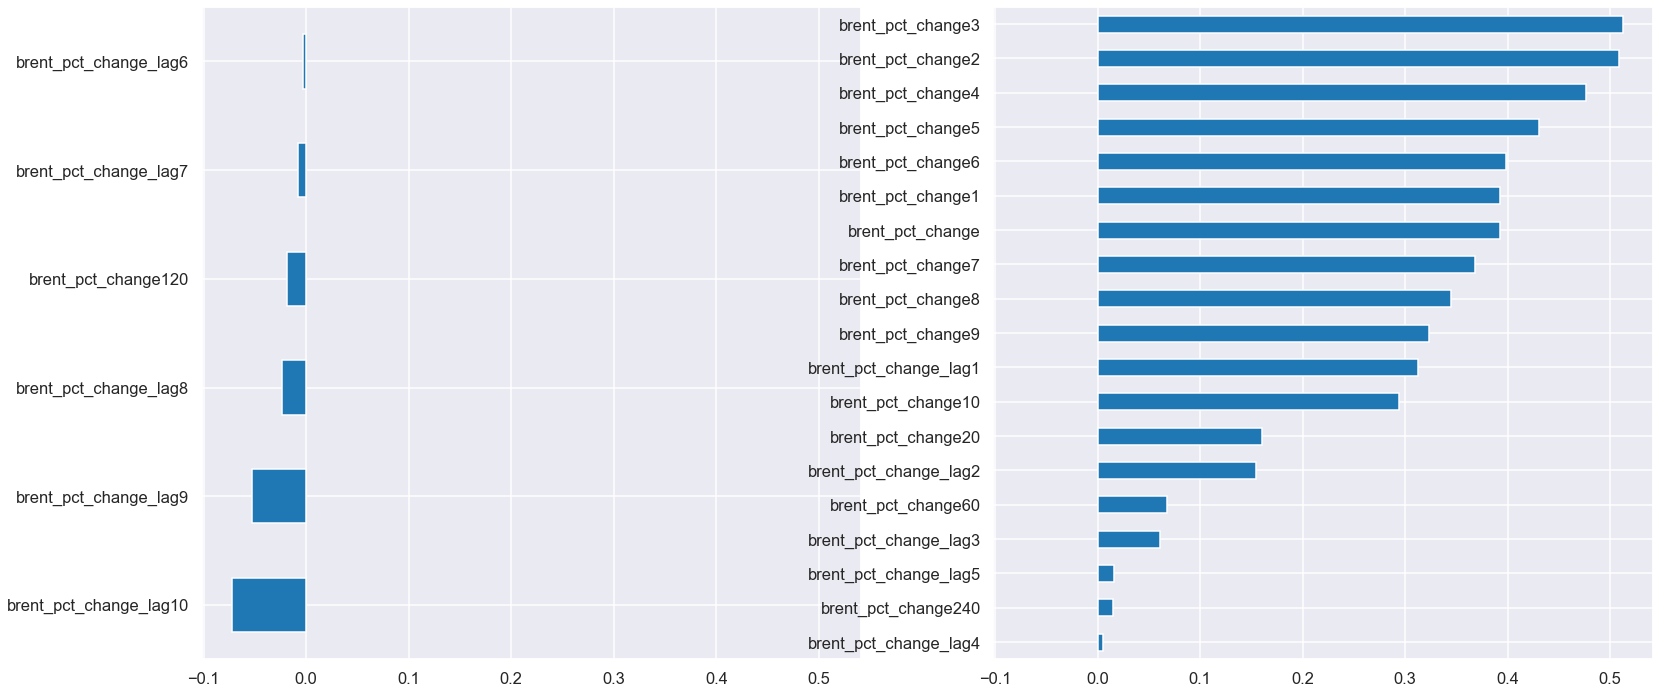

In [18]:
mle_viz.plot_corr_ranking(corr_s=corr_train_ar_s)

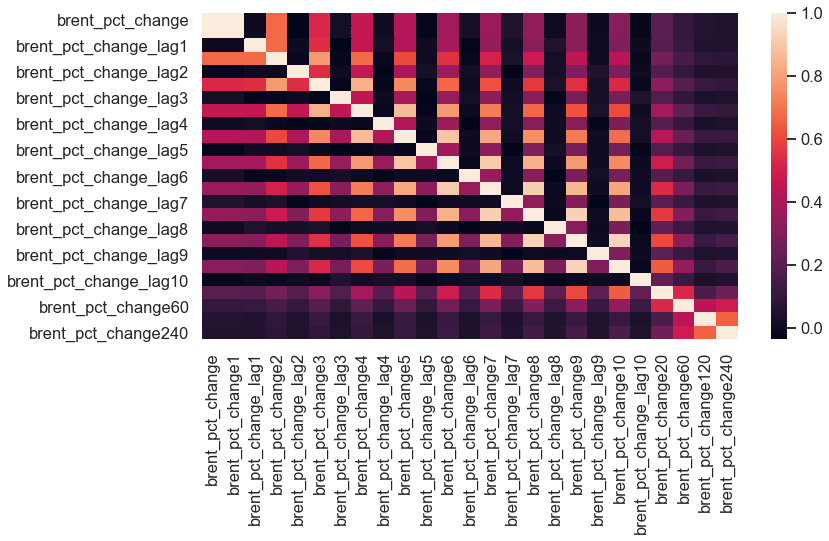

In [19]:
sns.heatmap(corr_train_ar_df.loc[ar_features, ar_features])
plt.show()

In [20]:
corr_train_ar_df.loc[
    ["brent_pct_change", "brent_pct_change2", "brent_pct_change3", "brent_pct_change_lag1", "brent_pct_change_lag10", 'brent_pct_change'],
    ["brent_pct_change", "brent_pct_change2", "brent_pct_change3", "brent_pct_change_lag1", "brent_pct_change_lag10", 'brent_pct_change']]

,brent_pct_change,brent_pct_change2,brent_pct_change3,brent_pct_change_lag1,brent_pct_change_lag10,brent_pct_change
brent_pct_change,1.0000,0.6740,0.5245,0.0005,-0.0226,1.0000
brent_pct_change2,0.6740,1.0000,0.7889,0.6783,-0.0144,0.6740
brent_pct_change3,0.5245,0.7889,1.0000,0.5447,-0.0044,0.5245
brent_pct_change_lag1,0.0005,0.6783,0.5447,1.0000,-0.0019,0.0005
brent_pct_change_lag10,-0.0226,-0.0144,-0.0044,-0.0019,1.0000,-0.0226
brent_pct_change,1.0000,0.6740,0.5245,0.0005,-0.0226,1.0000


## Cointegration Features

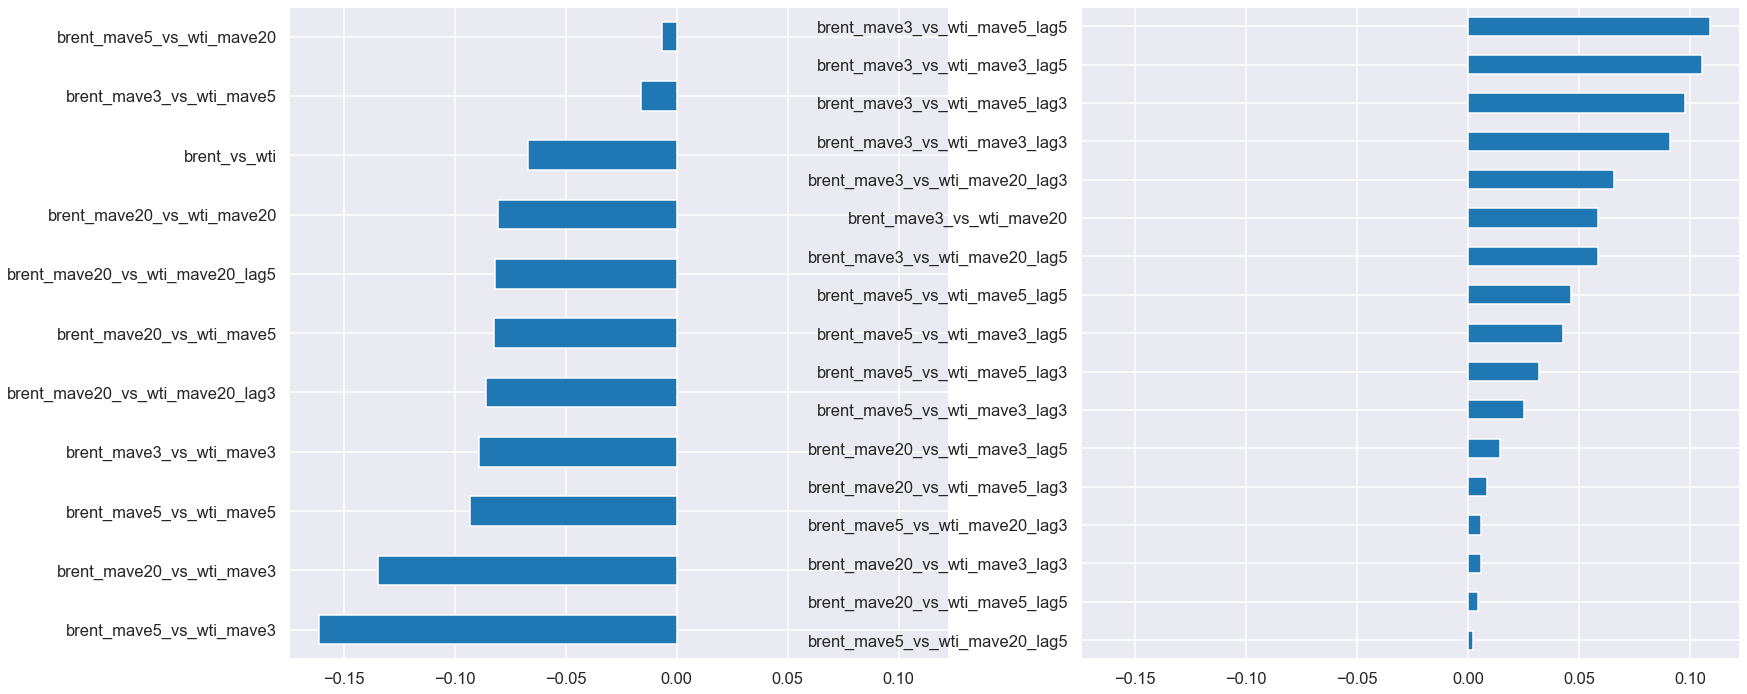

In [21]:
mle_viz.plot_corr_ranking(corr_s=corr_train_coint_s)

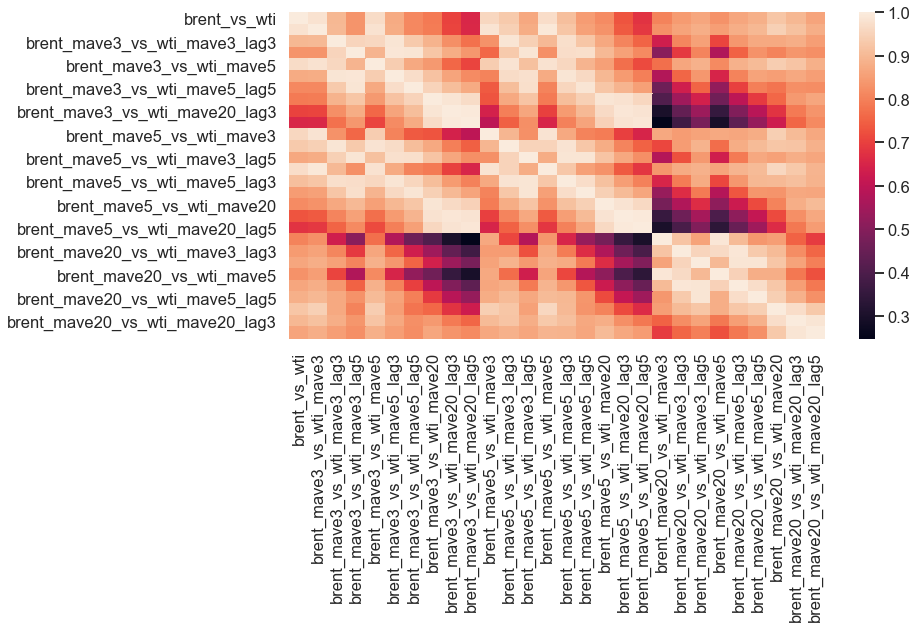

In [22]:
sns.heatmap(corr_train_coint_df.loc[coint_features, coint_features])
plt.show()

In [23]:
corr_train_coint_df.loc[
    ["brent_mave3_vs_wti_mave5_lag5", "brent_mave5_vs_wti_mave3"],
    ["brent_mave3_vs_wti_mave5_lag5", "brent_mave5_vs_wti_mave3"]
]

,brent_mave3_vs_wti_mave5_lag5,brent_mave5_vs_wti_mave3
brent_mave3_vs_wti_mave5_lag5,1.0000,0.7397
brent_mave5_vs_wti_mave3,0.7397,1.0000


## Seasonal Features

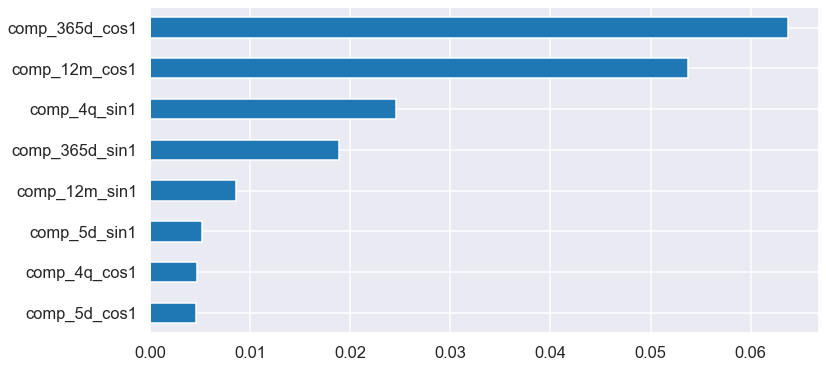

In [24]:
corr_train_seas_s.sort_values().plot.barh()
plt.show()

In [25]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'qtr'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     1.5236
pvalue   0.6768
dof      3.0000
dtype: float64

In [26]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'mon'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     32.8886
pvalue    0.0005
dof      11.0000
dtype: float64

In [27]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'weekday'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     0.7560
pvalue   0.9443
dof      4.0000
dtype: float64

## Event Features

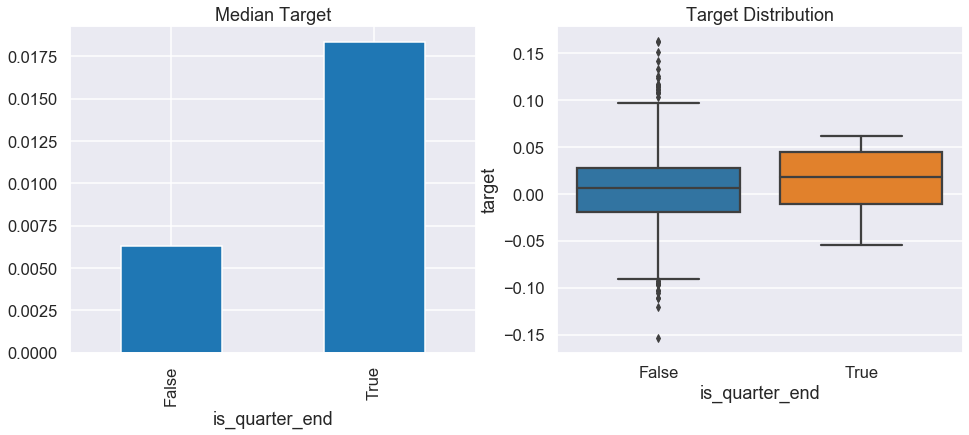

In [28]:
fig, axs = mle_viz.plot_target_props(y=comm_df.loc[:SPLIT_DT, 'target'], x_levels=comm_df.loc[:SPLIT_DT, 'is_quarter_end'])
plt.show()

In [29]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'is_quarter_end'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     0.0145
pvalue   0.9041
dof      1.0000
dtype: float64

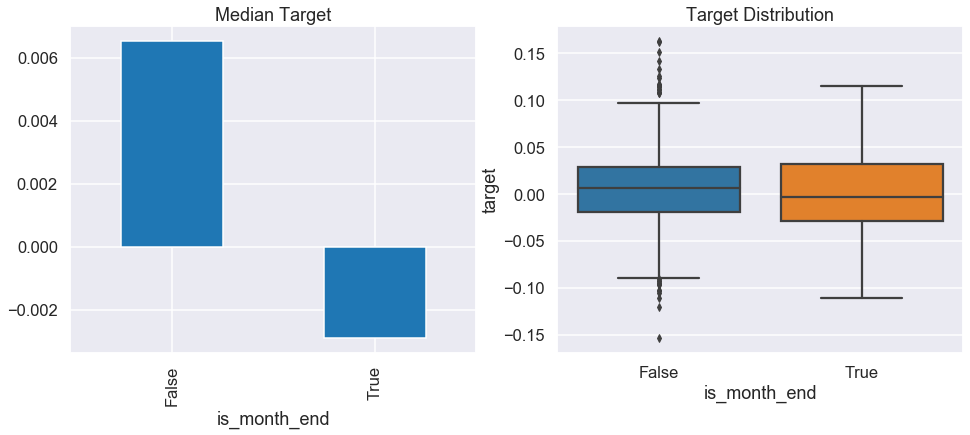

In [30]:
fig, axs = mle_viz.plot_target_props(y=comm_df.loc[:SPLIT_DT, 'target'], x_levels=comm_df.loc[:SPLIT_DT, 'is_month_end'])
plt.show()

In [31]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'is_month_end'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     3.5625
pvalue   0.0591
dof      1.0000
dtype: float64

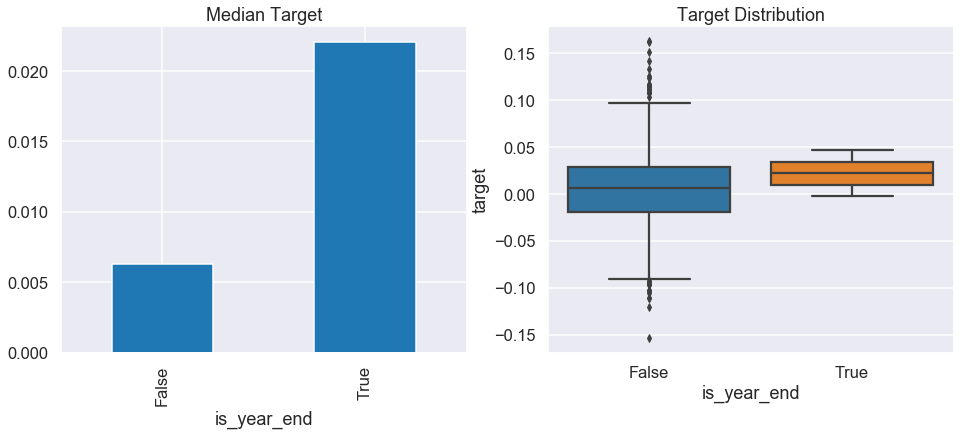

In [32]:
fig, axs = mle_viz.plot_target_props(y=comm_df.loc[:SPLIT_DT, 'target'], x_levels=comm_df.loc[:SPLIT_DT, 'is_year_end'])
plt.show()

In [33]:
mle_quant.run_chisq_test(comm_df.loc[:SPLIT_DT, 'is_year_end'], comm_df.loc[:SPLIT_DT, 'target']>0)

chi2     0.2288
pvalue   0.6324
dof      1.0000
dtype: float64

## Multicollinearity

In [34]:
select_features = [
    'brent_pct_change',  #brent_pct_change3  # Adds lots of multicollinearity
    'brent_pct_change_lag1','brent_pct_change_lag2', 'brent_pct_change_lag10',
    'is_month_end',
    'comp_365d_sin1', 'comp_365d_cos1',
    'brent_mave5_vs_wti_mave3' #  ,'brent_mave3_vs_wti_mave20'   # Adds lots of multicollinearity
]

In [35]:
corr_train_df.loc[select_features, 'target'].sort_values()

brent_mave5_vs_wti_mave3   -0.1610
brent_pct_change_lag10     -0.0724
is_month_end               -0.0283
comp_365d_sin1              0.0189
comp_365d_cos1              0.0637
brent_pct_change_lag2       0.1546
brent_pct_change_lag1       0.3122
brent_pct_change            0.3929
Name: target, dtype: float64

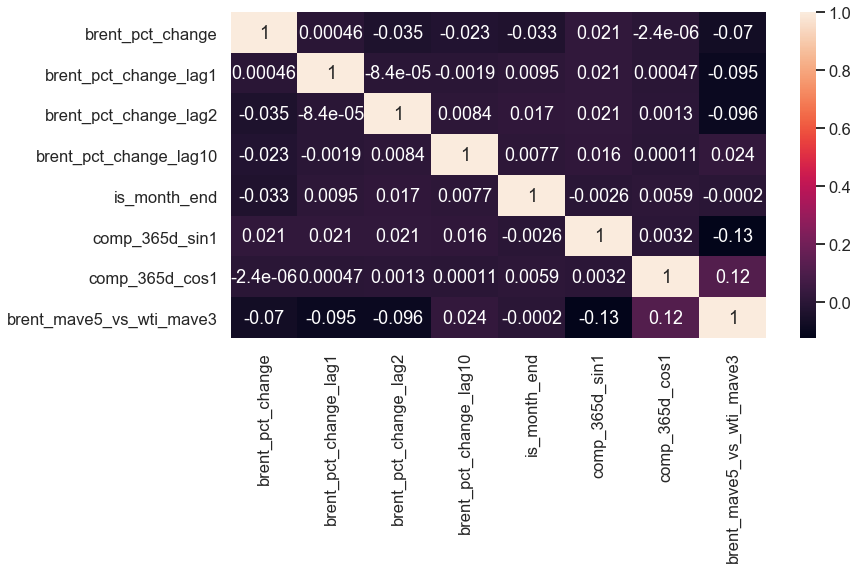

In [36]:
sns.heatmap(corr_train_df.loc[select_features, select_features], annot=True)
plt.show()